In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.DATA_HUB['dog_tiny']=(d2l.DATA_URL+'kaggle_dog_tiny.zip','0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo=True   # 如果使用Kaggle比赛的完整数据集，请将该变量更改为False
if demo:
    data_dir=d2l.download_extract('dog_tiny')
else:
    data_dir=os.path.join('..','data','dog-breed-identification')

In [3]:
def reorg_dog_data(data_dir,valid_ratio):
    labels=d2l.read_csv_labels(os.path.join(data_dir,'labels.csv'))
    d2l.reorg_train_valid(data_dir,labels,valid_ratio)
    d2l.reorg_test(data_dir)

batch_size=32 if demo else 128
valid_ratio=0.1
reorg_dog_data(data_dir,valid_ratio)

In [4]:
transform_train=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224,scale=(0.08,1.0),ratio=(3.0/4.0,4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

transform_test=torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

train_ds,train_valid_ds=[torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_train) for folder in ['train','train_valid']]
valid_ds,test_ds=[torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_test) for folder in ['valid','test']]

train_iter,train_valid_iter=[torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True) for dataset in (train_ds,train_valid_ds)]
valid_iter=torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)

In [12]:
def get_net(devices):
    finetune_net=nn.Sequential()
    finetune_net.features=torchvision.models.resnet34(pretrained=True)
    # 定义一个新的输出网络,共有120个输出类别
    finetune_net.output_new=nn.Sequential(nn.Linear(1000,256),nn.ReLU(),nn.Linear(256,120))
    nn.init.kaiming_uniform_(finetune_net.output_new[0].weight)
    nn.init.kaiming_uniform_(finetune_net.output_new[2].weight)
    finetune_net=finetune_net.to(devices[0])
    for params in finetune_net.features.parameters():
        params.requires_grad=False  # 冻结参数
    return finetune_net

loss=nn.CrossEntropyLoss(reduction='none')

def evaluate_loss_acc(data_iter,net,devices):
    """评估验证集上的损失和精度"""
    metric=d2l.Accumulator(3)
    for features,labels in data_iter:
        features,labels=features.to(devices[0]),labels.to(devices[0])
        outputs=net(features)
        l=loss(outputs,labels)
        metric.add(l.sum(),d2l.accuracy(outputs,labels),labels.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

def train(net,train_iter,valid_iter,num_epochs,lr,wd,devices):
    # 只训练小型自定义网络
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    trainer=torch.optim.SGD((param for param in net.parameters() if param.requires_grad),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(trainer,T_max=num_epochs)  # 余弦退火学习率
    num_batches,timer=len(train_iter),d2l.Timer()
    legend=['train loss','train acc']
    if valid_iter is not None:
        legend.extend(['valid loss','valid acc'])
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=legend)
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(3)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0])
            timer.stop()
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(metric[0]/metric[2],metric[1]/metric[2],None,None))
        if valid_iter is not None:
            valid_loss,valid_acc=evaluate_loss_acc(valid_iter,net,devices)
            animator.add(epoch+1,(None,None,valid_loss,valid_acc))
        scheduler.step()
    measures=(f'train loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}')
    if valid_iter is not None:
        measures+=f'\nvalid loss {valid_loss:.3f}, valid acc {valid_acc:.3f}'
    print(measures+f'\n{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')


train loss 0.721, train acc 0.843
valid loss 2.354, valid acc 0.635
466.2 examples/sec on [device(type='cuda', index=0)]


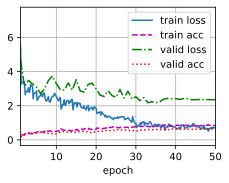

In [19]:
devices,num_epochs,lr,wd=d2l.try_all_gpus(),50,1e-3,5e-4
net=get_net(devices)
train(net,train_iter,valid_iter,num_epochs,lr,wd,devices)

train loss 0.715, train acc 0.837
466.1 examples/sec on [device(type='cuda', index=0)]


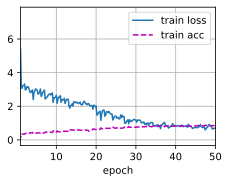

In [22]:
net=get_net(devices)
train(net,train_valid_iter,None,num_epochs,lr,wd,devices)
preds=[]
net.eval()
for data,label in test_iter:
    output=torch.nn.functional.softmax(net(data.to(devices[0])),dim=1)
    preds.extend(output.cpu().detach().numpy())
ids=sorted(os.listdir(os.path.join(data_dir,'train_valid_test','test','unknown')))
with open(os.path.join(data_dir,'submission.csv'),'w') as f:
    f.write('id,'+','.join(train_valid_ds.classes)+'\n')
    for i,output in zip(ids,preds):
        f.write(i.split('.')[0]+','+','.join([str(num) for num in output])+'\n')